### part0:imports

In [13]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import wilcoxon, mannwhitneyu, linregress
import math

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection

import torch

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        defs = params.random_walk_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'random_walk')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)
    print('Done')

import warnings
warnings.filterwarnings("ignore")

Done


### Get data

In [14]:
def get_full_random_walk_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList['MCx'].items():
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    allDFs_exec_MCx = []
    for animal, session in full_list_MCx:
        path = root/'random_walk'/animal/session
        df_ = defs.prep_general(dt.load_pyal_data(path))

        #separate into reaches
        df_ = defs.get_reaches_df(df_)
        df_['reach_id'] = range(len(df_))

        #subset center-out trials
        df_ = df_[df_.dist_start_center < defs.subset_radius]
        df_ = df_.reset_index()

        #execution epoch
        for col in df_.columns:  #TODO: placeholder to prevent bug in pyaldata
            if 'unit_guide' in col:
                df_ = df_.drop([col], axis = 1)
        df_ = pyal.add_movement_onset(df_)
        allDFs_MCx.append(df_)

        df_ = pyal.restrict_to_interval(df_, epoch_fun=defs.exec_epoch)
        allDFs_exec_MCx.append(df_)

        # print(len(df_))
        
    return full_list_MCx, allDFs_MCx, allDFs_exec_MCx

In [15]:
MCx_list, allDFs_MCx, allDFs_exec_MCx = get_full_random_walk_data()

In [16]:
ref_file = 'Chewie_RT_CS_2016-10-21.mat'
ref_i = [y for x,y in MCx_list].index(ref_file)

ex_file = 'Mihili_RT_VR_2014-01-15.mat'
ex_i = [y for x,y in MCx_list].index(ex_file)

df1 = allDFs_exec_MCx[ref_i]
df2 = allDFs_exec_MCx[ex_i]

In [17]:
print(len(allDFs_MCx[ref_i]), len(allDFs_exec_MCx[ref_i]))

allDFs_MCx[ref_i]

262 233


,index,monkey,date,task,target_center,trial_id,result,bin_size,perturbation,epoch,...,idx_reach_end,start_center,dist_start_center,pos_centered,target_centered,target_angle,target_group,reach_id,vel_norm,idx_movement_on
0,0,Chewie,10-21-2016,RT,"[-3.697366714477539, 1.4771696329116821]",2,R,0.03,CS,BL,...,32,NaN,0.982566,"[[0.0, 0.0], [0.18870511615661437, -0.08000648...","[-3.368770752341508, 2.403161672683421]",144.497285,3,0,"[7.37375241593462, 6.2545139516170645, 4.92026...",12.0
1,1,Chewie,10-21-2016,RT,"[7.688087463378906, -2.4862723350524902]",3,R,0.03,CS,BL,...,30,NaN,1.465336,"[[0.0, 0.0], [0.09444648355021454, -0.00789860...","[7.460475813926791, -1.038722131157435]",352.073663,7,4,"[4.036636438540328, 2.4504384978713625, 1.8089...",11.0
2,2,Chewie,10-21-2016,RT,"[3.5938963890075684, 4.453554630279541]",4,R,0.03,CS,BL,...,32,NaN,1.694967,"[[0.0, 0.0], [-0.04589297952659055, 0.04515767...","[2.9199006983002094, 6.008753741926949]",64.082976,1,8,"[1.919630642634355, 2.325294549272433, 2.32806...",10.0
3,2,Chewie,10-21-2016,RT,"[-5.591873645782471, 1.2230814695358276]",4,R,0.03,CS,BL,...,23,"[-0.6197371482849121, 0.695960521697998]",1.362462,"[[0.0, 0.0], [0.20262180228829507, -0.05656134...","[-4.845446771640748, 0.0832786706480988]",179.015355,3,11,"[7.2978455389601065, 6.519305529963075, 5.0407...",10.0
4,3,Chewie,10-21-2016,RT,"[-6.889117240905762, -3.605703115463257]",5,R,0.03,CS,BL,...,29,NaN,2.151682,"[[0.0, 0.0], [-0.09690631893749457, -0.0279482...","[-7.820625229034328, -1.6661079900673919]",192.026513,4,12,"[3.3717861681790238, 3.2800261968399624, 2.832...",9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,282,Chewie,10-21-2016,RT,"[4.670343399047852, 1.570024013519287]",387,R,0.03,CS,BL,...,19,NaN,2.111067,"[[0.0, 0.0], [-0.4003197554177309, -0.00936147...","[2.6581480799058688, 2.208516331247772]",39.721421,0,1126,"[14.072098504426293, 12.121958260493459, 10.30...",8.0
258,283,Chewie,10-21-2016,RT,"[-6.66745138168335, -0.47665584087371826]",389,R,0.03,CS,BL,...,22,NaN,1.270516,"[[0.0, 0.0], [0.08389165528650955, 0.299998992...","[-5.8530699354313755, 0.49853309777606114]",175.131603,3,1130,"[11.198475105118375, 9.445754102005555, 7.5045...",10.0
259,284,Chewie,10-21-2016,RT,"[-6.590362548828125, -7.954090595245361]",390,R,0.03,CS,BL,...,27,NaN,0.857976,"[[0.0, 0.0], [-0.10301530292595018, 0.14217576...","[-7.364005190207659, -7.583145716096272]",225.839955,5,1134,"[6.316291134747753, 5.517520435541971, 4.78301...",10.0
260,285,Chewie,10-21-2016,RT,"[-4.397096633911133, 0.6931866407394409]",393,R,0.03,CS,BL,...,23,NaN,1.579465,"[[0.0, 0.0], [-0.17731623481189962, -0.2400833...","[-5.5214502424186245, -0.41610940379128536]",184.309797,4,1138,"[10.22058844815843, 9.633924608591759, 9.13637...",12.0


#### Plot reaches for datasets

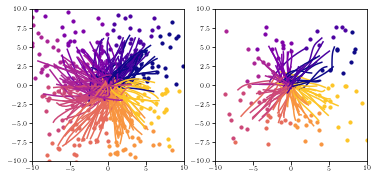

In [18]:
#plot centered reaches for each dataset
colors = utility.get_colors(defs.n_target_groups)
fig, axs = plt.subplots(ncols=2)
for j, df_ in enumerate([df1,df2]):
    for i in range(len(df_)):
        pos = df_.pos_centered.values[i]
        targets = df_.target_centered.values[i]
        target_group = df_.target_group.values[i]
        axs[j].plot(*pos[:].T, c=colors[target_group])
        axs[j].scatter(*targets[:].T, s = 10, c=colors[target_group])
    axs[j].set_aspect(1)
    axs[j].set_xlim([-10,10])
    axs[j].set_ylim([-10,10])

#### Match reaches using different methods
Matching based on MSE for position seems most accurate

In [19]:
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

print('Ntrials:', len(df1), len(df2))

#match by target
df1_targets = np.vstack(df1.target_centered)
df2_targets = np.vstack(df2.target_centered)
distances = cdist(df1_targets,df2_targets,metric = 'euclidean')
# fig, ax = plt.subplots()
# ax.imshow(distances)
closest_dist = np.min(distances.T, axis = 1)
closest_targets = np.argmin(distances.T, axis = 1)

# plt.figure()
# plt.hist((closest_dist).flatten(), color = 'b', histtype='step')
# plt.hist((distances).flatten(), color = 'r', histtype='step')
# df1_pos = np.vstack(df1.pos_centered)
# df2_pos = np.vstack(df2.pos_centered)

# match by pos corr or mse
corrs = np.zeros([len(df1), len(df2)])
mses = np.zeros([len(df1), len(df2)])
for i, pos1 in enumerate(df1.pos_centered):
    for j, pos2 in enumerate(df2.pos_centered):
        # if j<i: continue
        r = [pearsonr(aa,bb)[0] for aa,bb in zip(pos1.T,pos2.T)]
        mse = np.mean((pos1-pos2)**2)
        corrs[i][j] = np.mean(r)
        mses[i][j] = mse
        # corrs[j][i] = np.mean(np.abs(r))
max_corrs = np.max(corrs.T, axis = 1)
closest_corr = np.argmax(corrs.T, axis = 1)

min_mses = np.min(mses.T, axis = 1)
closest_pos = np.argmin(mses.T, axis = 1)
# df1_pos = np.vstack(df1.pos_centered)
# df2_pos = np.vstack(df2.pos_centered)
# df1_pos.shape
# df1_targets.shape

Ntrials: 233 93


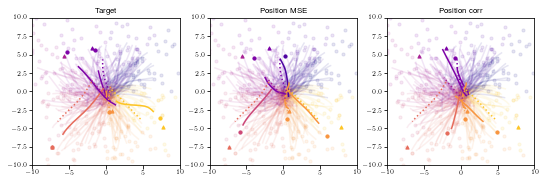

In [20]:
#plot different criteria for matching
criteria = [closest_targets, closest_pos, closest_corr]
col_names = ['Target', 'Position MSE', 'Position corr']

fig,axs = plt.subplots(ncols=len(criteria), figsize = (3*len(criteria), 3))
colors = utility.get_colors(defs.n_target_groups)
ntrials = 5

for j, crit in enumerate(criteria):
    df = df1
    for i in range(len(df)):
        pos = df.pos_centered.values[i]
        targets = df.target_centered.values[i]
        target_group = df.target_group.values[i]
        axs[j].plot(*pos[:].T, c=colors[target_group], alpha = 0.1)
        axs[j].scatter(*targets[:].T, s = 10, c=colors[target_group], alpha = 0.1)

    df = df1.iloc[crit]
    for i in range(ntrials):
        pos = df.pos_centered.values[i]
        targets = df.target_centered.values[i]
        target_group = df.target_group.values[i]
        axs[j].plot(*pos[:].T, c=colors[target_group])
        axs[j].scatter(*targets[:].T, s = 10, c=colors[target_group])

    df = df2
    for i in range(ntrials):
        pos = df.pos_centered.values[i]
        targets = df.target_centered.values[i]
        target_group = df.target_group.values[i]
        axs[j].plot(*pos[:].T, c=colors[target_group], linestyle = 'dotted')
        axs[j].scatter(*targets[:].T, s = 10, c=colors[target_group],marker = '^')
    axs[j].set_aspect(1)
    axs[j].set_xlim([-10,10])
    axs[j].set_ylim([-10,10])

for i in range(len(col_names)):
    axs[i].set_title(col_names[i])

#### Get non-repeating matched reaches (using MSE position)

In [21]:
import collections 

#get indices for matching reaches in the two dataframes
n_matches = collections.Counter(closest_pos)
df1_idx = []
df2_idx = []
for i, df1_match in enumerate(closest_pos):
    #don't include duplicate matches
    if df1_match in df1_idx: continue
    #save matches
    elif n_matches[df1_match] == 1:
        df2_match = i
        df1_idx.append(df1_match)
        df2_idx.append(df2_match)
    #choose best match, TODO: use target as next criteria
    else:
        #elements in df2 that match df1
        df2_matches = np.argwhere(closest_pos == df1_match) 
        mse_matches = min_mses[df2_matches]
        df2_best_match = df2_matches[np.argmin(mse_matches)]
        df1_idx.append(df1_match)
        df2_idx.append(df2_best_match[0])

(-10.0, 10.0)

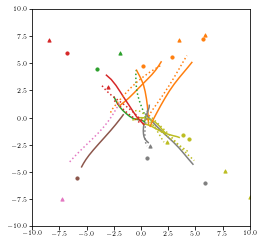

In [22]:
#subset dataframes with matched reaches
df1_subset = df1.iloc[df1_idx]
df2_subset = df2.iloc[df2_idx]

#plot matched reaches
ntrials = 10
colors = utility.get_colors(defs.n_target_groups, 'tab10')
plt.figure()
df = df1_subset
for i in range(ntrials):
    pos = df.pos_centered.values[i]
    targets = df.target_centered.values[i]
    target_group = df.target_group.values[i]
    plt.plot(*pos[:].T, c=colors[target_group])
    plt.scatter(*targets[:].T, s = 10, c=colors[target_group])

df = df2_subset
for i in range(ntrials):
    pos = df.pos_centered.values[i]
    targets = df.target_centered.values[i]
    target_group = df.target_group.values[i]
    plt.plot(*pos[:].T, c=colors[target_group], linestyle = 'dotted')
    plt.scatter(*targets[:].T, s = 10, c=colors[target_group],marker = '^')
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])

In [23]:
#set target ids
print(df1_subset.target_group.values[:10])
print(df2_subset.target_group.values[:10])

df1_subset.target_group = df2_subset.target_group.values #TODO: fix and redefine this
df1_subset['target_id'] = df1_subset.target_group.values
df2_subset['target_id'] = df2_subset.target_group.values

print(df1_subset.target_group.values[:10])
print(df2_subset.target_group.values[:10])

print(collections.Counter(df1_subset.target_group))
print(collections.Counter(df2_subset.target_group))


[1 6 6 4 2 7 1 7 1 3]
[2 6 7 5 3 7 1 7 1 3]
[2 6 7 5 3 7 1 7 1 3]
[2 6 7 5 3 7 1 7 1 3]
Counter({6: 12, 7: 11, 2: 9, 1: 7, 4: 7, 0: 6, 5: 5, 3: 5})
Counter({6: 12, 7: 11, 2: 9, 1: 7, 4: 7, 0: 6, 5: 5, 3: 5})


61
28


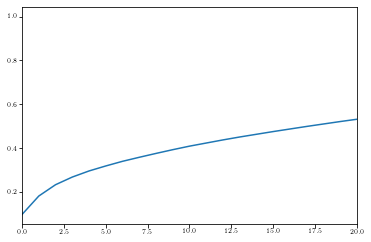

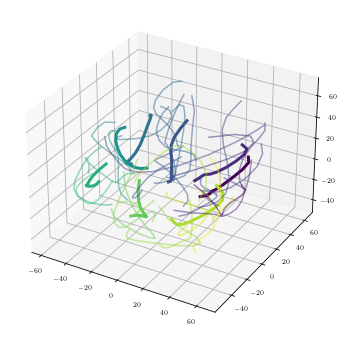

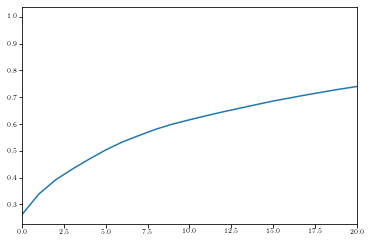

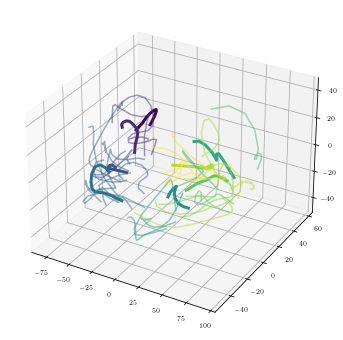

In [24]:
# %matplotlib widget
%matplotlib inline
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(0, 360)
for df_ in [df1_subset,df2_subset]:
    #check dimensionality
    model = pyal.fit_dim_reduce_model(df_, PCA(), 'MCx_rates')
    dim = (np.nonzero((np.cumsum(model.explained_variance_ratio_) > 0.8))[0][0])
    print(dim)
    df_ = pyal.dim_reduce(df_, PCA(10), 'MCx_rates', '_pca')
    
    plt.figure()
    plt.plot(np.cumsum(model.explained_variance_ratio_))
    plt.xlim([0,20])

    # plot PCA
    colors = utility.get_colors(defs.n_target_groups, 'viridis')
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(projection = '3d')

    for tar in range(defs.n_target_groups):
        df__ = pyal.select_trials(df_, df_.target_group==tar)
        ex = pyal.get_sig_by_trial(df__,'_pca')
        ex = np.mean(ex, axis=2)[:,:3]
        ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=3)
        # ax.view_init(60,-47)

    # for i in range(len(df_)):
    for i in range(30):
        pca = df_._pca.values[i]
        angle = df_.target_angle.values[i]
        ax.plot(pca[:,0],pca[:,1],pca[:,2],c=cmap(norm(angle)), alpha=0.5)


In [31]:
df1_ = pd.DataFrame({'reach_id':df1_subset.reach_id}).merge(allDFs_MCx[ref_i])
df2_ = pd.DataFrame({'reach_id':df2_subset.reach_id}).merge(allDFs_MCx[ex_i])

#set target ids
print(df1_.target_group.values[:10])
print(df2_.target_group.values[:10])

df1_.target_group = df2_.target_group.values #TODO: fix and redefine this
df1_['target_id'] = df1_.target_group.values
df2_['target_id'] = df2_.target_group.values

print(df1_.target_group.values[:10])
print(df2_.target_group.values[:10])

print(collections.Counter(df1_.target_group))
print(collections.Counter(df2_.target_group))


[1 6 6 4 2 7 1 7 1 3]
[2 6 7 5 3 7 1 7 1 3]
[2 6 7 5 3 7 1 7 1 3]
[2 6 7 5 3 7 1 7 1 3]
Counter({6: 12, 7: 11, 2: 9, 1: 7, 4: 7, 0: 6, 5: 5, 3: 5})
Counter({6: 12, 7: 11, 2: 9, 1: 7, 4: 7, 0: 6, 5: 5, 3: 5})


(1, 8, 5, 12, 10)


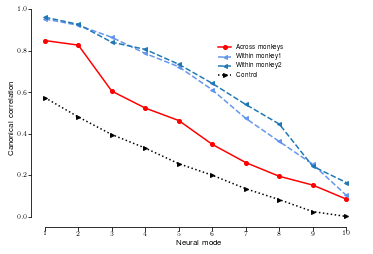

In [32]:
#cca
AllData1 = dt.get_data_array(df1_, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
AllData2 = dt.get_data_array(df2_, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
print(AllData1.shape) #session x target_groups x trials x time x modes

_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
allCCs=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
    allCCs.append(dt.canoncorr(data1, data2))
allCCs = np.array(allCCs).T
    
# lower bound
len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))
AllDataL1 = defs._get_data_array(df1_, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
AllDataL2 = defs._get_data_array(df2_, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllDataL1.shape,AllDataL2.shape),axis=0)
CCsL=[]
for sessionData1,sessionData2 in zip(AllDataL1,AllDataL2):
    r = []
    for n in range(params.n_iter * 10):
        sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
        sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
        data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        r.append(dt.canoncorr(data1, data2))
    CCsL.append(r)
CCsL = np.array(CCsL)
CCsL = np.percentile(CCsL, 1, axis=1).T
    
# upper bound
AllDataU = dt.get_data_array([df1_,df2_], epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
n_shared_trial1 = AllDataU.shape[2]
trialList1 = np.arange(n_shared_trial1)
CCsU=[]
for session, sessionData in enumerate(AllDataU):
    r = []
    for n in range(params.n_iter * 10):
        params.rng.shuffle(trialList1)
        # non-overlapping randomised trials
        trial1 = trialList1[:n_shared_trial1//2]
        trial2 = trialList1[-(n_shared_trial1//2):]
        data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
        r.append(dt.canoncorr(data1, data2))
    CCsU.append(r)
CCsU = np.array(CCsU)
CCsU = np.percentile(CCsU, 99, axis=1).T

# plotting
fig, ax = plt.subplots()
x_ = np.arange(1,defs.n_components+1)
ax.plot(x_, allCCs, color=params.colors.MainCC, marker = 'o', label=f'Across monkeys')
ax.plot(x_, CCsU[:,0], color=params.colors.UpperCC, marker = '<', ls='--', label=f'Within monkey1')
ax.plot(x_, CCsU[:,1], marker = '<', ls='--', label=f'Within monkey2')
ax.plot(x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':', label=f'Control')


ax.set_ylim([-.05,1])
ax.set_xlim([.6,defs.n_components+.6])
ax.set_xlabel('Neural mode')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set_title(f'{defs.areas[2]} Alignment')
ax.legend(loc=(.55,.67))
ax.set_ylabel('Canonical correlation')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds([1,defs.n_components])
ax.spines['left'].set_bounds([0,1])